In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
np.random.seed(42)

lines = []
fin = open("alicewonderland.txt", "rb")
for line in fin:
    line = line.strip().decode("ascii", "ignore").encode("utf-8").decode("utf-8")
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()

In [4]:
lines

["Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll",
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 "Title: Alice's Adventures in Wonderland",
 'Author: Lewis Carroll',
 'Posting Date: June 25, 2008 [EBook #11]',
 'Release Date: March, 1994',
 '[Last updated: December 20, 2011]',
 'Language: English',
 'Character set encoding: ASCII',
 "*** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***",
 "ALICE'S ADVENTURES IN WONDERLAND",
 'Lewis Carroll',
 'THE MILLENNIUM FULCRUM EDITION 3.0',
 'CHAPTER I. Down the Rabbit-Hole',
 'Alice was beginning to get very tired of sitting by her sister on the',
 'bank, and of having nothing to do: once or twice she had peeped into the',
 'book her sister was reading, but it had no pictures or c

In [5]:
sents = nltk.sent_tokenize(" ".join(lines))

tokenizer = Tokenizer(5000)  # use top 5000 words only
tokens = tokenizer.fit_on_texts(sents)
vocab_size = len(tokenizer.word_counts) + 1

xs = []
ys = []
for sent in sents:
    embedding = one_hot(sent, vocab_size)
    triples = list(nltk.trigrams(embedding))
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)

In [11]:
triples

[(5, 804, 2273),
 (804, 2273, 1870),
 (2273, 1870, 1016),
 (1870, 1016, 665),
 (1016, 665, 804),
 (665, 804, 1983),
 (804, 1983, 943),
 (1983, 943, 842),
 (943, 842, 106),
 (842, 106, 2601),
 (106, 2601, 842),
 (2601, 842, 2643),
 (842, 2643, 2865)]

In [76]:
from keras.preprocessing.sequence import skipgrams

words = []
contexts = []
ys = []

for sent in sents:
    embedding = one_hot(sent, vocab_size)
    x,y = skipgrams( embedding, vocab_size )    
    word = [x[0] for x in x]
    context = [x[1] for x in x]
    
    words.extend(word)
    contexts.extend(context)
    ys.extend(y)

In [97]:
W.shape

(427892, 3338)

In [100]:
%%time
ohe = OneHotEncoder(n_values=vocab_size)

W = ohe.fit_transform(np.array(words).reshape(-1, 1)).todense()
C = ohe.fit_transform(np.array(contexts).reshape(-1, 1)).todense()
Y = np.array(ys)

Wtrain, Wtest, Ctrain, Ctest, Ytrain, Ytest = train_test_split( W, C, Y, test_size=0.3, random_state=42)

print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(599048, 3338) (256736, 3338) (299524,) (128368,)
Wall time: 28.8 s


In [116]:
from keras.layers import Activation, Embedding, dot, Reshape, Input
from keras.models import Sequential, Model

input_targetword = Input(shape=(vocab_size,))
inputs_context = Input(shape=(vocab_size,))
target_word = Dense(30)(input_targetword)
context = Dense(30)(inputs_context)

drop_context = Dropout(0.4)(context)
drop_target = Dropout(0.4)(target_word)

ddot = dot([drop_target, drop_context], 1)
reshape = Reshape((1,), input_shape=(1, 1))(ddot)
net_output = Activation('sigmoid')(reshape)

model = Model(inputs=[input_targetword, inputs_context], outputs=[net_output])

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 3338)         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 3338)         0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 30)           100170      input_19[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 30)           100170      input_20[0][0]                   
__________________________________________________________________________________________________
dropout_8 

In [117]:
history = model.fit([Wtrain, Ctrain], Ytrain, batch_size=BATCH_SIZE,
                    epochs=5, verbose=1,
                    validation_data=([Wtest, Ctest], Ytest))

Train on 299524 samples, validate on 128368 samples
Epoch 1/5
299524/299524 [==============================] - 29s 95us/step - loss: 0.4079 - val_loss: 0.3414
Epoch 2/5
299524/299524 [==============================] - 28s 93us/step - loss: 0.3478 - val_loss: 0.3377
Epoch 3/5
299524/299524 [==============================] - 28s 94us/step - loss: 0.3433 - val_loss: 0.3364
Epoch 4/5
299524/299524 [==============================] - 28s 93us/step - loss: 0.3405 - val_loss: 0.3358
Epoch 5/5
299524/299524 [==============================] - 28s 92us/step - loss: 0.3381 - val_loss: 0.3359


In [118]:
from keras.utils import plot_model
plot_model(model, to_file='ns-sg-softmax.png')

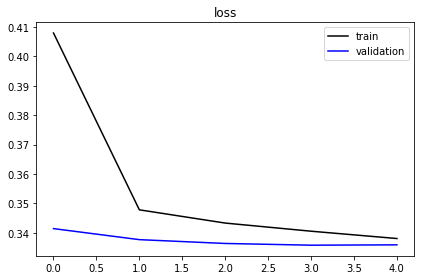

In [119]:

# plot loss function
plt.title("loss")
plt.plot(history.history["loss"], color="k", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [132]:
# evaluate model
score = model.evaluate( [Wtest, Ctest], Ytest, verbose=1)
print("Test score: {:.3f}".format(score))

# using the word2vec model
word2idx = tokenizer.word_index
idx2word = {v: k for k, v in word2idx.items()}

# retrieve the weights from the first dense layer. This will convert
# the input vector from a one-hot sum of two words to a dense 300
# dimensional representation
W, b = model.layers[3].get_weights()

128368/128368 [==============================] - 8s 61us/step
Test score: 0.336


In [133]:
W.shape

(3338, 30)

In [134]:
idx2emb = {}
for word in word2idx.keys():
    wid = word2idx[word]
    vec_in = ohe.fit_transform(np.array(wid)).todense()
    vec_emb = np.dot(vec_in, W)
    idx2emb[wid] = vec_emb

for word in ["stupid", "alice", "succeeded"]:
    wid = word2idx[word]
    source_emb = idx2emb[wid]
    distances = []
    for i in range(1, vocab_size):
        if i == wid:
            continue
        target_emb = idx2emb[i]
        distances.append(((wid, i),
                         cosine_distances(source_emb, target_emb)))
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [idx2word[x[0][1]] for x in sorted_distances]
    print("{:s} => {:s}".format(word, ", ".join(predictions)))

stupid => explain, 'catch, attends, named, fainting, yourself, shall, begins, their, denied
alice => top, away, 'cheshire, wondering, unpleasant, created, interest, tail, flying, gloves
succeeded => beheading, violent, given, afraid, processions, comfort, clinging, everything, entrance, rabbit'


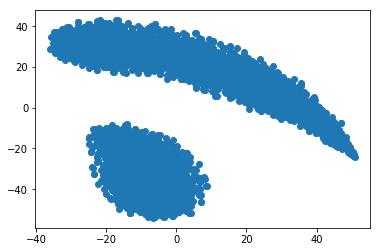

In [135]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

In [137]:
W.shape

(3338, 30)

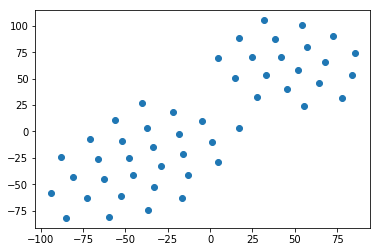

In [139]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[1:50,:])

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)